## Project : 
- Implement the gradient and stochastic gradient methods for LASSO. 
- Numerically study the effect of the step size on convergence. 
- Study the effect of the choice of mini-batch size.


The `error_plot` function takes an error vector `ys` as input and creates a plot of error values across iterations, with a customizable y-axis scale (default is logarithmic). This function is essential for visualizing the convergence behavior of the optimization algorithm over time.


In [1]:
from IPython.display import display, HTML
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random

np.random.seed(1337)


kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)
    
def error_plot(ys, ax=None, yscale='log', **kwargs):
    # If no axes are passed, create a new figure
    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()  # Get the current active axes

    ax.set_xlabel('Step')
    ax.set_ylabel('Error')
    ax.set_yscale(yscale)
    ax.plot(range(len(ys)), ys, **kwargs)



## Projected gradient descent (already given code) : 

This function implements the gradient descent process, with the option to project points using the proj function. It starts from the initial point, then iterates over a list of step sizes, applying the gradient and the projection at each iteration. This is useful for both unconstrained and constrained optimization problems, depending on whether or not a projection function is used.


In [2]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

### Least Squares Objective and Gradient

These functions define the least squares objective and its gradient, which will be used later for implementing gradient-based optimization methods like gradient descent.

#### Least Squares Objective:
The least squares problem aims to minimize the squared difference between the observed values and the values predicted by a linear model. Mathematically, the objective function is defined as:

$$
f(x) = \frac{1}{2m} \|Ax - b\|^2
$$

- `A`: The matrix of features.
- `b`: The vector of observed values (target).
- `x`: The vector of model parameters.
- `m`: The number of samples (implicitly assumed in the function).

This function computes the objective value based on the norm of the residuals, where the residuals are the differences between the predicted and actual values.

#### Gradient of Least Squares Objective:
The gradient of the least squares objective function, which is required for gradient-based optimization, is given by:

$$
\nabla f(x) = \frac{1}{m} A^T(Ax - b)
$$

- The gradient measures the direction and rate of change of the objective function with respect to the parameter vector `x`.
- The function `least_squares_gradient` computes this gradient, which is used to update the model parameters during optimization.

Both functions are critical for implementing the gradient descent algorithm in the context of least squares regression.


In [3]:
def least_squares(A, b, x):
    """Least squares objective."""
    return (0.5/m) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    """Gradient of least squares objective at x."""
    return A.T.dot(A.dot(x)-b)/m

### LASSO Objective and Subgradient

These functions define the LASSO objective, its \( \ell_1 \)-norm subgradient, and the combined subgradient of the LASSO objective function.

#### LASSO Objective:
The LASSO objective function combines the least squares objective with an \( \ell_1 \)-norm regularization term. This regularization encourages sparsity in the solution, which is useful for feature selection. Mathematically, the LASSO objective is:

$$
f(x) = \frac{1}{2m} \|Ax - b\|^2 + \alpha \|x\|_1
$$

- `A`: Feature matrix.
- `b`: Observed values.
- `x`: Model parameters.
- `\alpha`: Regularization parameter that controls the strength of the \( \ell_1 \)-regularization (default is 0.1).

The term \( \alpha \|x\|_1 \) adds a penalty proportional to the sum of absolute values of the model parameters, which promotes sparse solutions (i.e., many elements of \( x \) are zero).

#### Subgradient of the \( \ell_1 \)-Norm:
The \( \ell_1 \)-norm is not differentiable at zero, but its subgradient can be defined. The subgradient of \( \|x\|_1 \) is:

$$
g_i(x) = 
\begin{cases}
1, & x_i > 0 \\
-1, & x_i < 0 \\
[-1, 1], & x_i = 0
\end{cases}
$$

In the code, the `ell1_subgradient` function computes this subgradient.

#### LASSO Subgradient:
The subgradient of the full LASSO objective is obtained by adding the gradient of the least squares objective to the subgradient of the \( \ell_1 \)-norm:

$$
\nabla f(x) = \frac{1}{m} A^T(Ax - b) + \alpha \cdot \partial \|x\|_1
$$

The `lasso_subgradient` function computes this combined subgradient, which is used in optimization algorithms such as subgradient descent for LASSO.


In [4]:
def lasso(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + alpha * np.linalg.norm(x, 1)

def ell1_subgradient(x):
    """Subgradient of the ell1-norm at x."""
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def lasso_subgradient(A, b, x, alpha=0.1):
    """Subgradient of the lasso objective at x"""
    return least_squares_gradient(A, b, x) + alpha*ell1_subgradient(x)

### Important 

This setup tests how well the LASSO regualization helps us to converge towards a global minimum when we have an undetermined case (number of features > number of observations). The gradient descent method optimizes the LASSO objective and find a sparse solution, while the plot visualizes the convergence behavior.

### Synthetic Data Generation and Gradient Descent for LASSO

In this code cell, synthetic data is generated for testing the LASSO optimization using projected gradient descent. The error over iterations is plotted to observe the convergence of the algorithm.

#### Data Setup:
- `m = 100`: Number of data points (rows in matrix \( A \)).
- `n = 1000`: Number of features (columns in matrix \( A \)).
- `A = np.random.normal(0, 1, (m, n))`: Random matrix \( A \), generated with values from a normal distribution.
- `x_opt = np.zeros(n)`: Optimal solution vector initialized to zeros.
- `x_opt[:10] = 1.0`: The first 10 elements of the optimal solution are set to 1. This makes the true solution sparse, which aligns with the goal of LASSO to find sparse solutions.
- `b = A.dot(x_opt)`: Vector of observed values obtained by multiplying \( A \) with the sparse true solution \( x_{\text{opt}} \).

#### Gradient Descent for LASSO:
- `x0 = np.random.normal(0, 1, n)`: Random initialization (generated with values from a normal distribution) of the starting point for gradient descent.
- `gradient_descent`: The gradient descent algorithm is applied to minimize the LASSO objective, using a fixed step size of 0.1 for 500 iterations. The LASSO subgradient is passed as the gradient function.

#### Plotting Error:
- The error at each step is computed using the `lasso` function, and the `error_plot` function visualizes the error values over the iterations to track convergence.



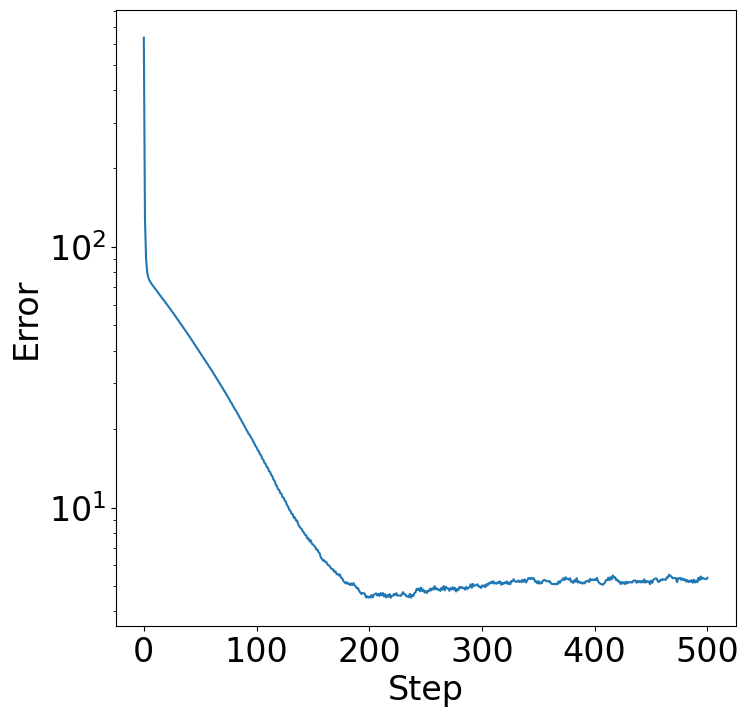

In [5]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, lambda x: lasso_subgradient(A, b, x))
error_plot([lasso(A, b, x) for x in xs])

### Comparison of Initial, Optimal, and Final Points

This code visualizes a comparison between the initial, optimal, and final solutions after running the gradient descent algorithm. The comparison is plotted for the first 50 coordinates of the solution vectors.
  
#### Data Plotted:
- `idxs = range(50)`: Only the first 50 coordinates are plotted for easier visualization.
- `x0[idxs]`: The initial point (before gradient descent) is shown using a dashed gray line (`'--'`, color `#aaaaaa`).
- `x_opt[idxs]`: The optimal point (true sparse solution) is shown using a solid red line (`'r-'`).
- `xs[-1][idxs]`: The final computed solution (after gradient descent) is shown using a solid green line (`'g-'`).

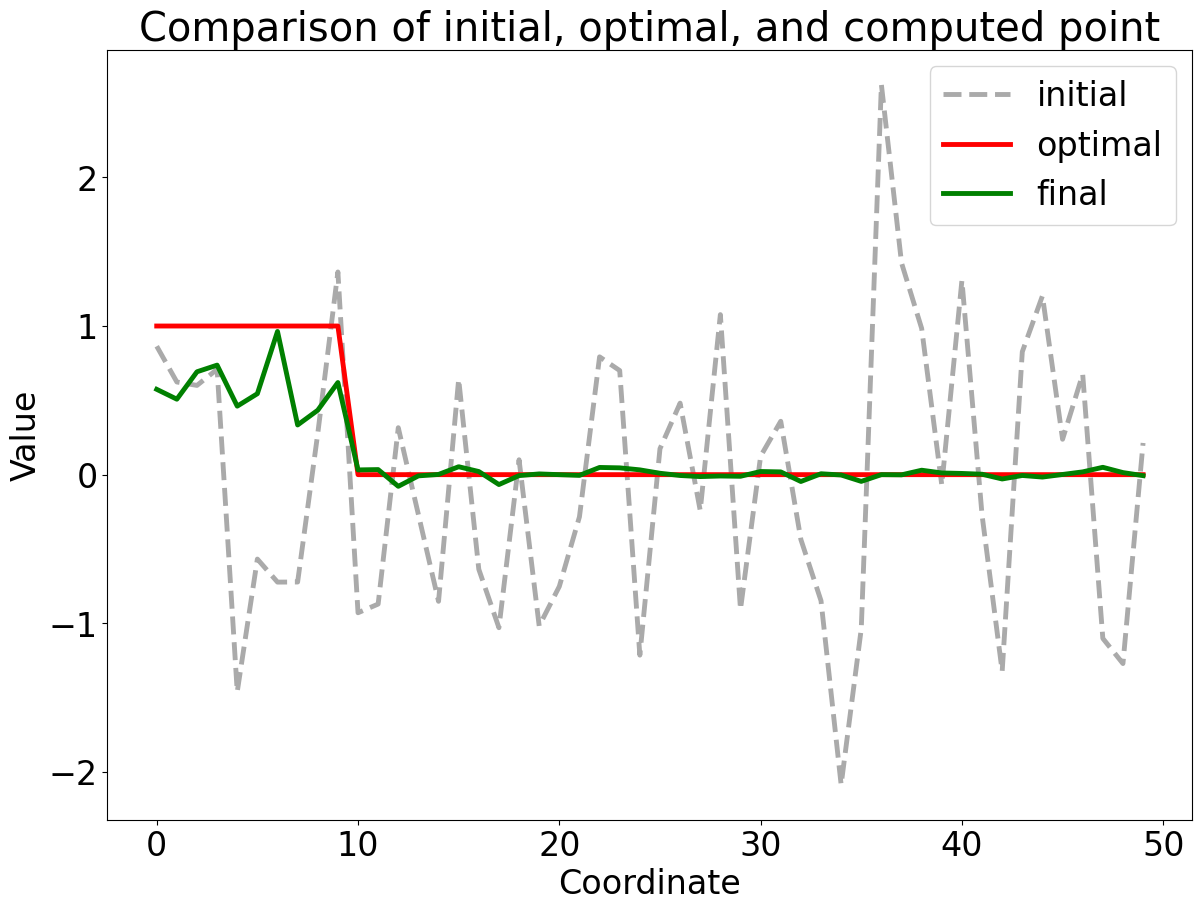

In [6]:
plt.figure(figsize=(14,10))
plt.title('Comparison of initial, optimal, and computed point')
idxs = range(50)
plt.plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial', **kwargs)
plt.plot(idxs, x_opt[idxs], 'r-', label='optimal', **kwargs)
plt.plot(idxs, xs[-1][idxs], 'g-', label='final', **kwargs)
plt.xlabel('Coordinate')
plt.ylabel('Value')
plt.legend()


### Testing Different Step Sizes for Gradient Descent in LASSO

This code performs a comparison of gradient descent with different step sizes to observe their effects on the convergence behavior. For each step size, two plots are generated: one for the error across iterations and another to compare the initial, optimal, and final points.

#### Step Sizes Tested:
- `steps = [0.001, 0.01, 0.1, 0.5]`: Four different step sizes are tested, ranging from very small (0.001) to relatively large (0.5).
- `iterations = [10000, 10000, 10000, 10]`: The number of iterations for gradient descent is adjusted based on the step size. Smaller step sizes require more iterations for convergence, while larger step sizes may need fewer iterations.

#### Plot Descriptions:
1. **Error Plot:**
   - The first subplot shows the error over the iterations for each step size. The error is calculated using the LASSO objective function.
   - The goal is to observe how the error decreases over time and how the step size affects the convergence speed.

2. **Comparison Plot:**
   - The second subplot compares the initial point (before gradient descent), the optimal point (true solution), and the final point (after gradient descent) for the first 50 coordinates.
   - This helps visualize how closely the computed solution (after gradient descent) approximates the true optimal solution.


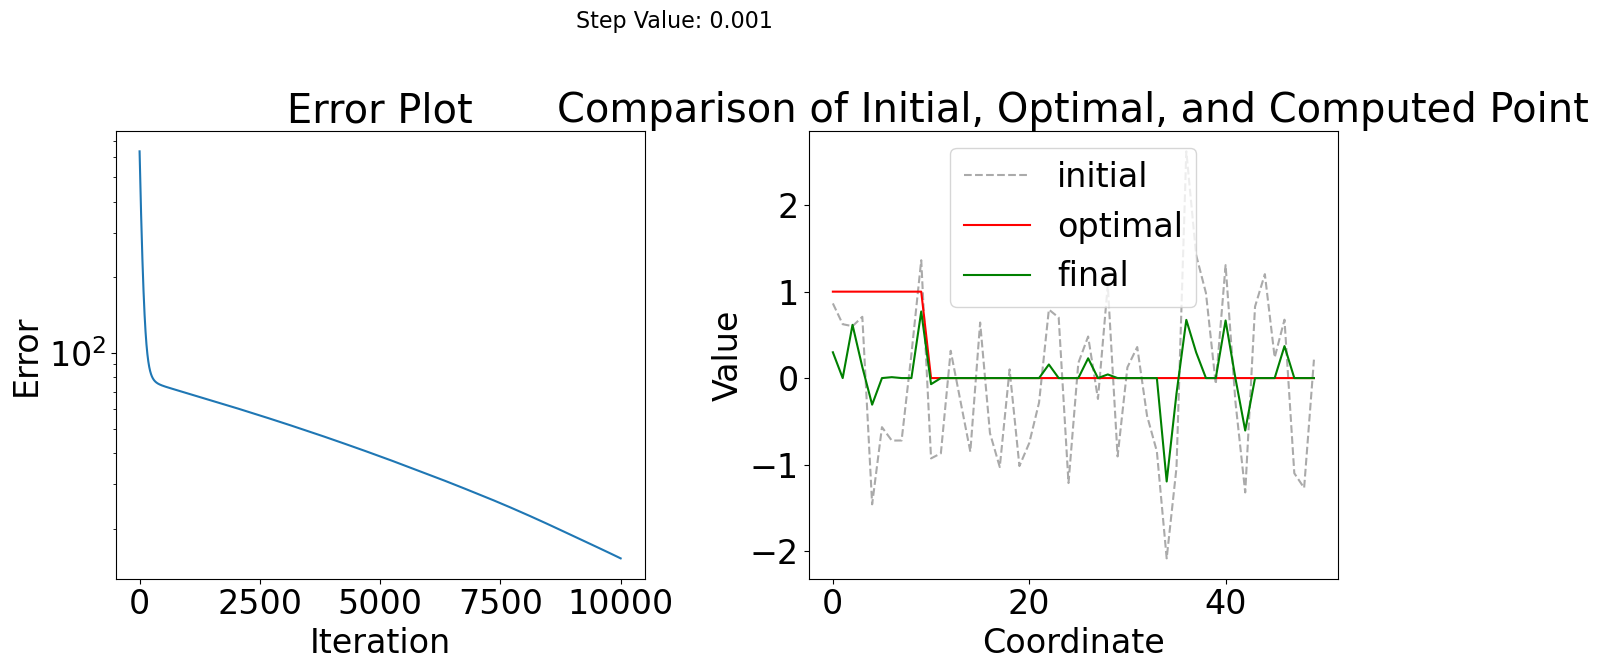

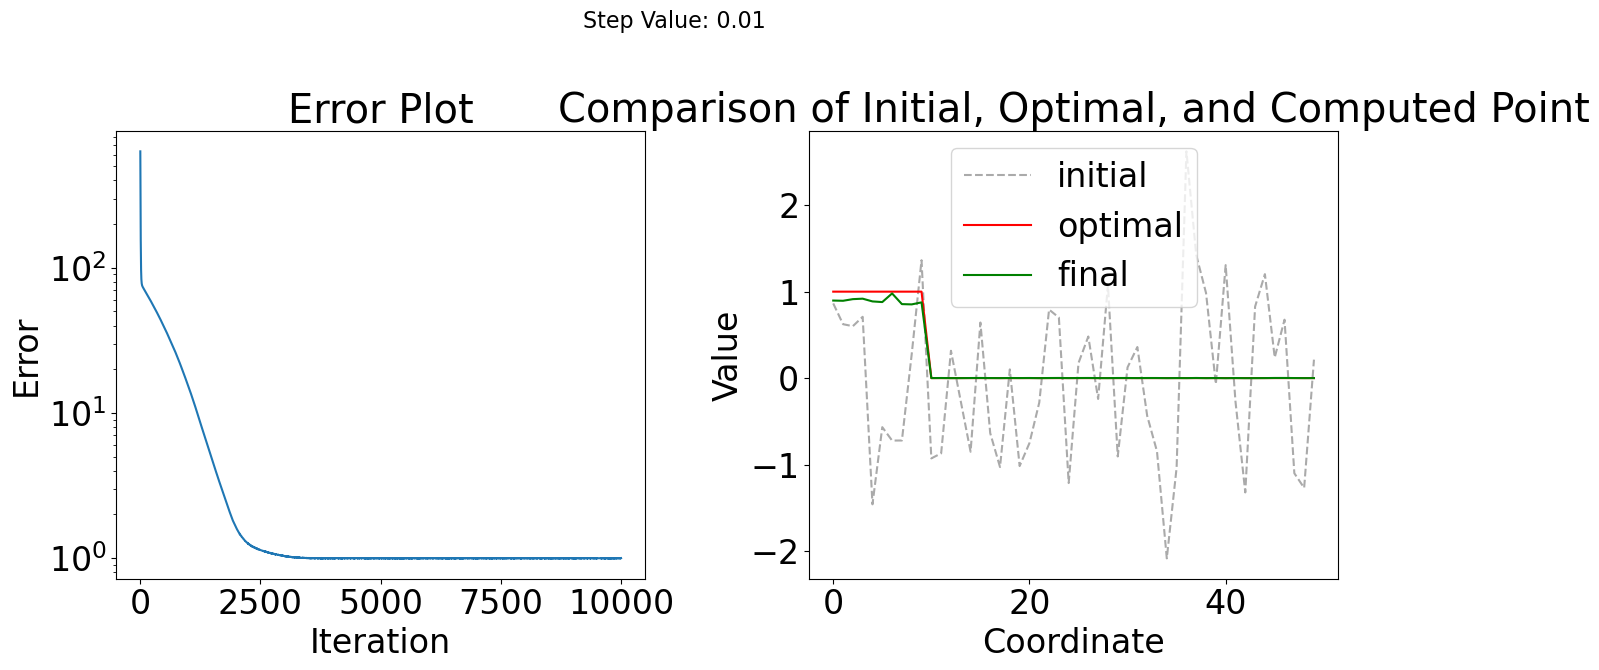

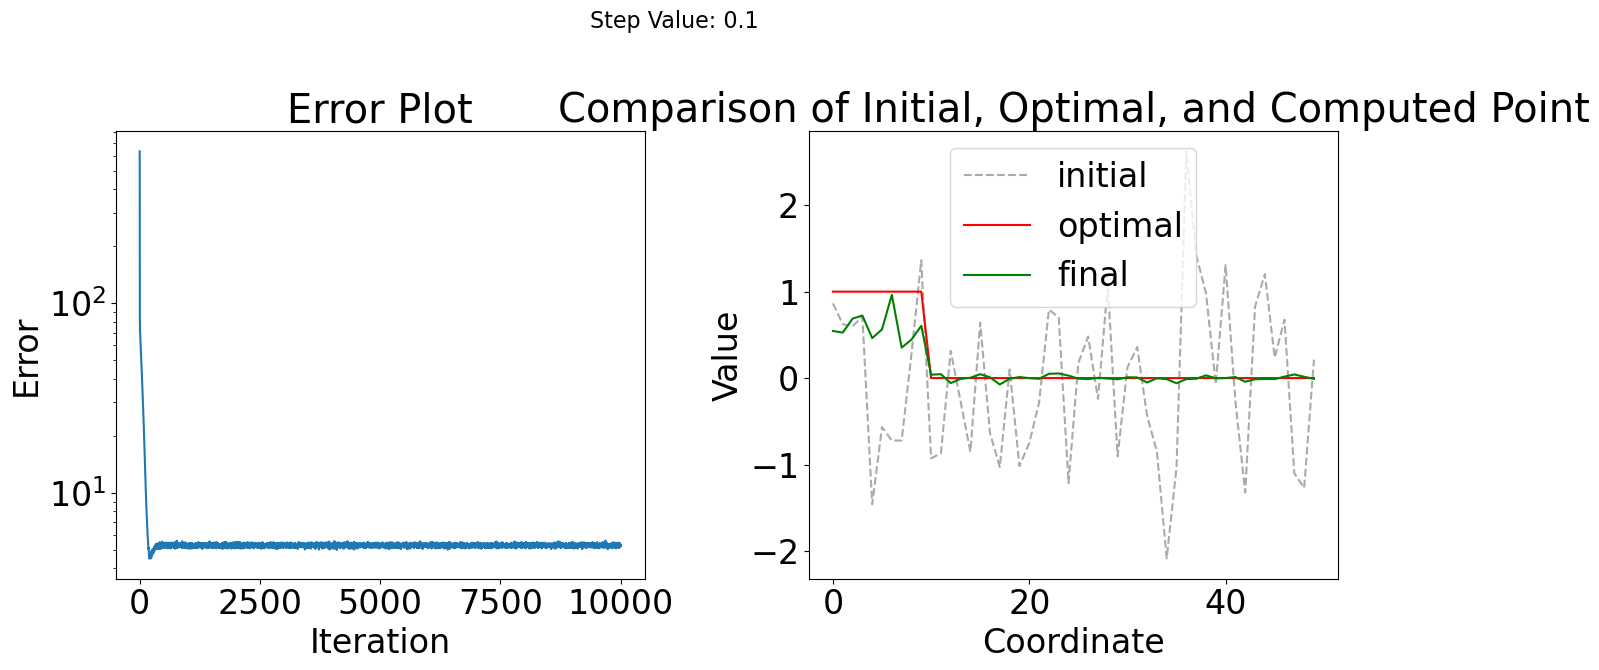

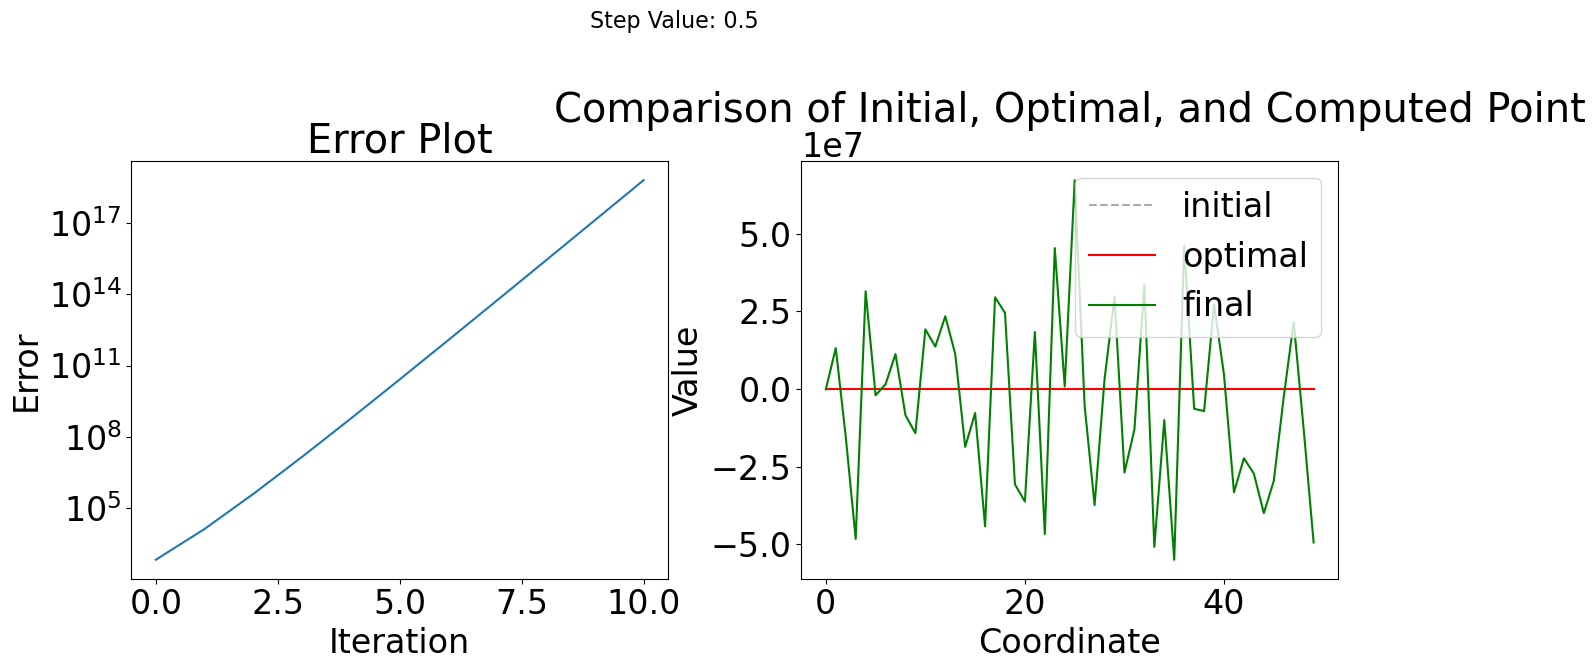

In [7]:
steps = [0.001, 0.01, 0.1, 0.5]
iterations = [10000,10000,10000,10]
list_xs = []

for index, step in enumerate(steps):
    # Perform gradient descent
    list_xs.append(gradient_descent(x0, [step] * iterations[index], lambda x: lasso_subgradient(A, b, x)))

    # Create a new figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Set the overall figure title including the step value
    fig.suptitle(f'Step Value: {step}', fontsize=16)

    # First subplot: error plot
    error_plot([lasso(A, b, x) for x in list_xs[index]], ax=axes[0])  # Pass axes[0] to error_plot
    axes[0].set_title('Error Plot')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Error')

    # Second subplot: comparison plot
    idxs = range(50)
    axes[1].plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial')
    axes[1].plot(idxs, x_opt[idxs], 'r-', label='optimal')
    axes[1].plot(idxs, list_xs[index][-1][idxs], 'g-', label='final')
    axes[1].set_title('Comparison of Initial, Optimal, and Computed Point')
    axes[1].set_xlabel('Coordinate')
    axes[1].set_ylabel('Value')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the figure with both subplots side by side
    plt.show()



### Analysis of the plots : 

Step Size: 0.001 – The algorithm converges slowly but steadily, requiring many iterations to reach an accurate solution.

Step Size: 0.01 – Faster convergence than 0.001 with good accuracy, balancing speed and stability.

Step Size: 0.1 – Very fast convergence with slight deviations in accuracy for a few coordinates.

Step Size: 0.5 – The algorithm diverges completely, making the step size too large for proper convergence.


As promised, LASSO correctly identifies the significant coordinates of the optimal solution. This is why, in practice, LASSO is a popular tool for feature selection.

### Stochastic Gradient Descent (SGD) for Least Squares, LASSO

This set of functions implements stochastic gradient descent (SGD) for optimizing least squares, LASSO regression.

#### SGD for Least Squares Gradient:
- `SGD_least_squares_gradient` computes the gradient of the least squares objective using a randomly selected mini-batch of observations from matrix `A` with size `batch`.
- This allows the gradient to be computed on a subset of data, speeding up the optimization process for large datasets.



In [8]:
def SGD_least_squares_gradient(A, b, x, batch):
    """Gradient of least squares objective at x."""
    
    # Randomly choose an index from the array
    random_index = np.random.choice(len(A), batch, replace=False)

    # Get the value at the chosen index
    random_observation = A[random_index]

    return random_observation.T.dot(random_observation.dot(x)-b[random_index])/batch

def ell1_subgradient(x):
    """Subgradient of the ell1-norm at x."""
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def SGD_lasso_subgradient(A, b, x, alpha=1, batch_size = 5):
    """Subgradient of the lasso objective at x"""
    return SGD_least_squares_gradient(A, b, x, batch=batch_size) + alpha*ell1_subgradient(x)

def SGD_elastic_net_gradient(A, b, x, alpha1=0.1, alpha2=0.1):
    return SGD_least_squares_gradient(A, b, x) + alpha1 * ell1_subgradient(x) + alpha2 * x


### Stochastic Gradient Descent with LASSO for Different Step Sizes

This code performs stochastic gradient descent (SGD) for the LASSO problem with three different step sizes. For each step size, two plots are generated to observe the convergence behavior and compare the solutions.

#### Setup:
- **Steps and Iterations:** Three different step sizes (`0.001`, `0.01`, `0.1`) are tested, with corresponding iteration counts. Smaller step sizes require more iterations for convergence.

#### Stochastic Gradient Descent with LASSO:
- **Mini-Batch Size:** The gradient is computed using mini-batches of size 20 (`batch_size=20`), and the \( \ell_1 \)-norm regularization parameter is set to `alpha=0.05`.
- **SGD for LASSO:** The LASSO objective is optimized using the `gradient_descent` function, where the gradient is replaced with the `SGD_lasso_subgradient` function to introduce mini-batches and stochasticity.

#### Observations:
- Step Size: 0.001: This step size is too small, resulting in very slow convergence even after many iterations.
- Step Size: 0.01: This step size provides the best balance, achieving fast and stable convergence with accurate results.
- Step Size: 0.1: This step size is too large, causing the algorithm to diverge and the error to explode.

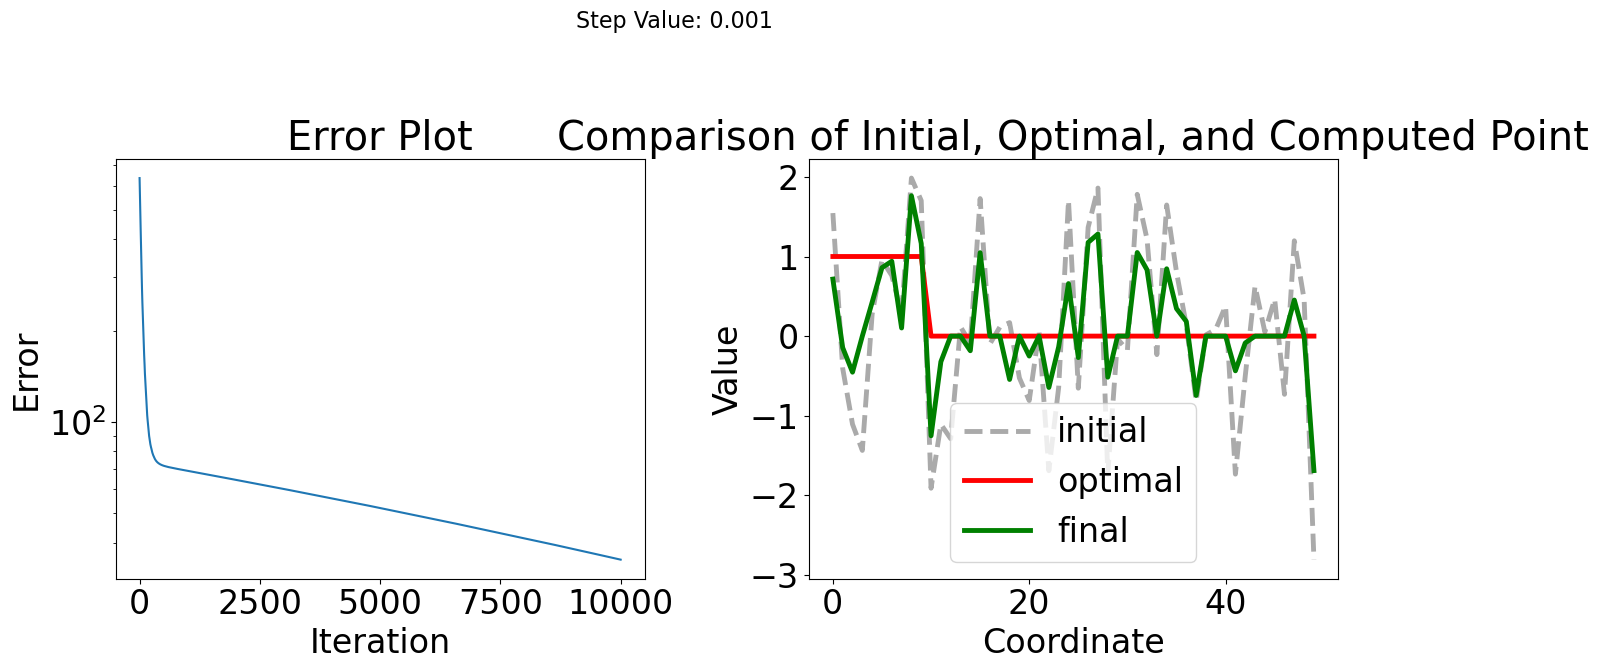

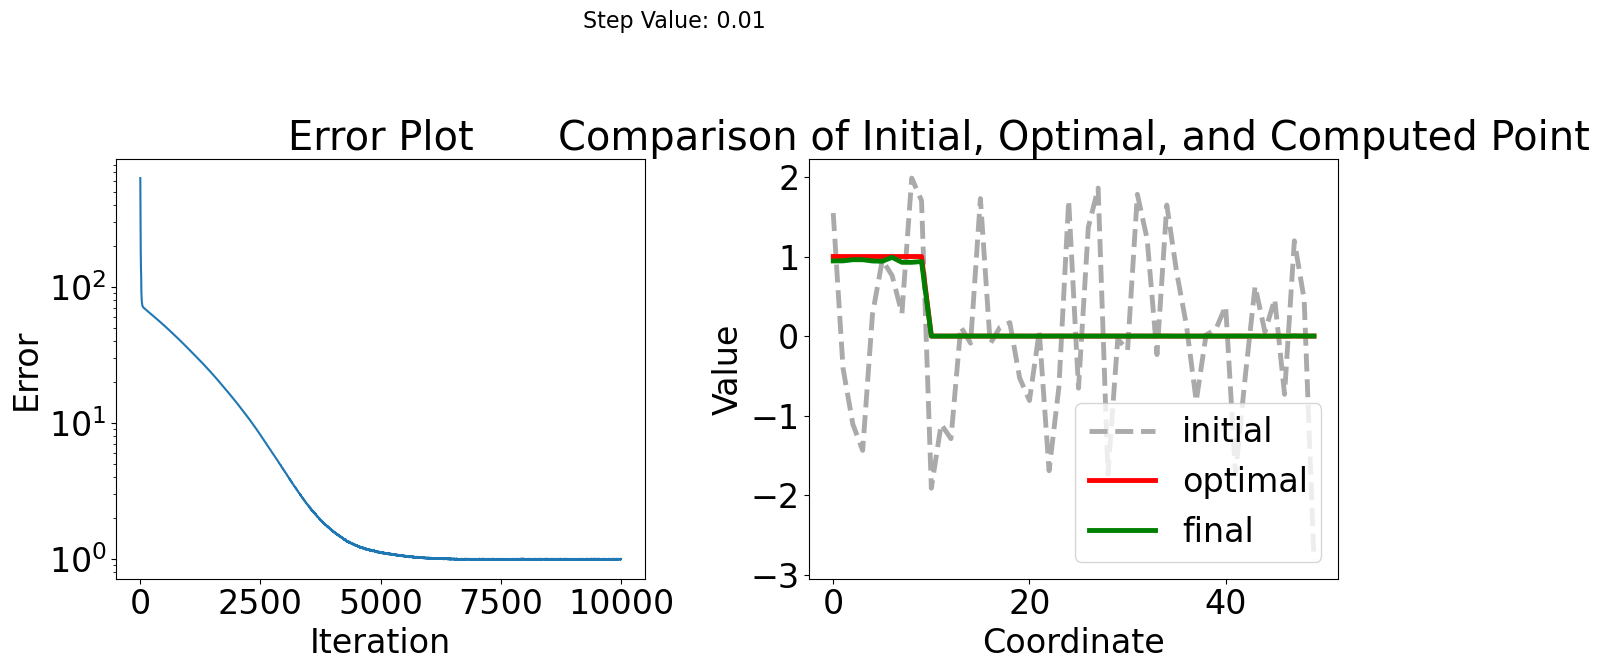

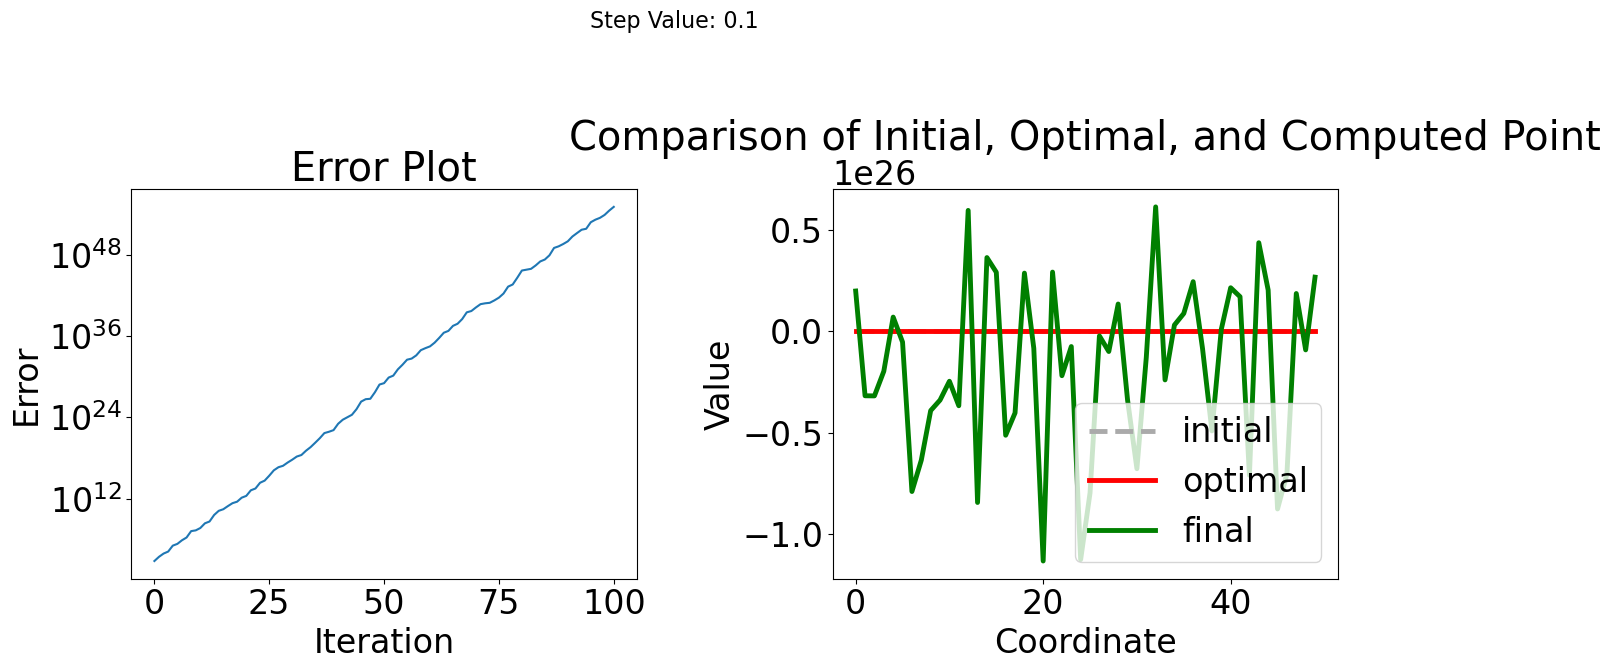

In [9]:
m, n = 100, 1000
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)

steps = [0.001, 0.01, 0.1]
iterations = [10000,10000,100]

list_xs_ = []

for index, step in enumerate(steps):
    # Perform stochastic gradient descent with Lasso
    list_xs_.append(gradient_descent(x0, [step] * iterations[index], lambda x: SGD_lasso_subgradient(A, b, x, alpha=0.05, batch_size=20)))

    # Create a new figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Set the overall figure title to include the step value
    fig.suptitle(f'Step Value: {step}', fontsize=16)

    # First subplot: error plot
    error_plot([lasso(A, b, x) for x in list_xs_[-1]], ax=axes[0])  # Pass axes[0] to error_plot
    axes[0].set_title('Error Plot')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Error')

    # Second subplot: comparison plot
    idxs = range(50)
    axes[1].plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial', **kwargs)
    axes[1].plot(idxs, x_opt[idxs], 'r-', label='optimal', **kwargs)
    axes[1].plot(idxs, list_xs_[index][-1][idxs], 'g-', label='final', **kwargs)
    axes[1].set_title('Comparison of Initial, Optimal, and Computed Point')
    axes[1].set_xlabel('Coordinate')
    axes[1].set_ylabel('Value')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the title

    # Show the figure with both subplots side by side
    plt.show()


### Stochastic Gradient Descent with LASSO: Effect of Different Batch Sizes

This code explores the impact of different batch sizes on the performance of stochastic gradient descent (SGD) with LASSO by testing four different batch sizes: 5, 10, 20, and 100.
#### Observations:
- Batch Size: 5: Too small, causing high variability and potential gradient explosion unless the step size is very small.
- Batch Size: 10: Improved stability with steady error reduction and accurate final solution.
- Batch Size: 20: Even more stable, with smooth error reduction and closely matching the optimal solution.
- Batch Size: 100 (Full Dataset): Most stable, similar to traditional gradient descent, yielding the best results in both error and coordinate accuracy.



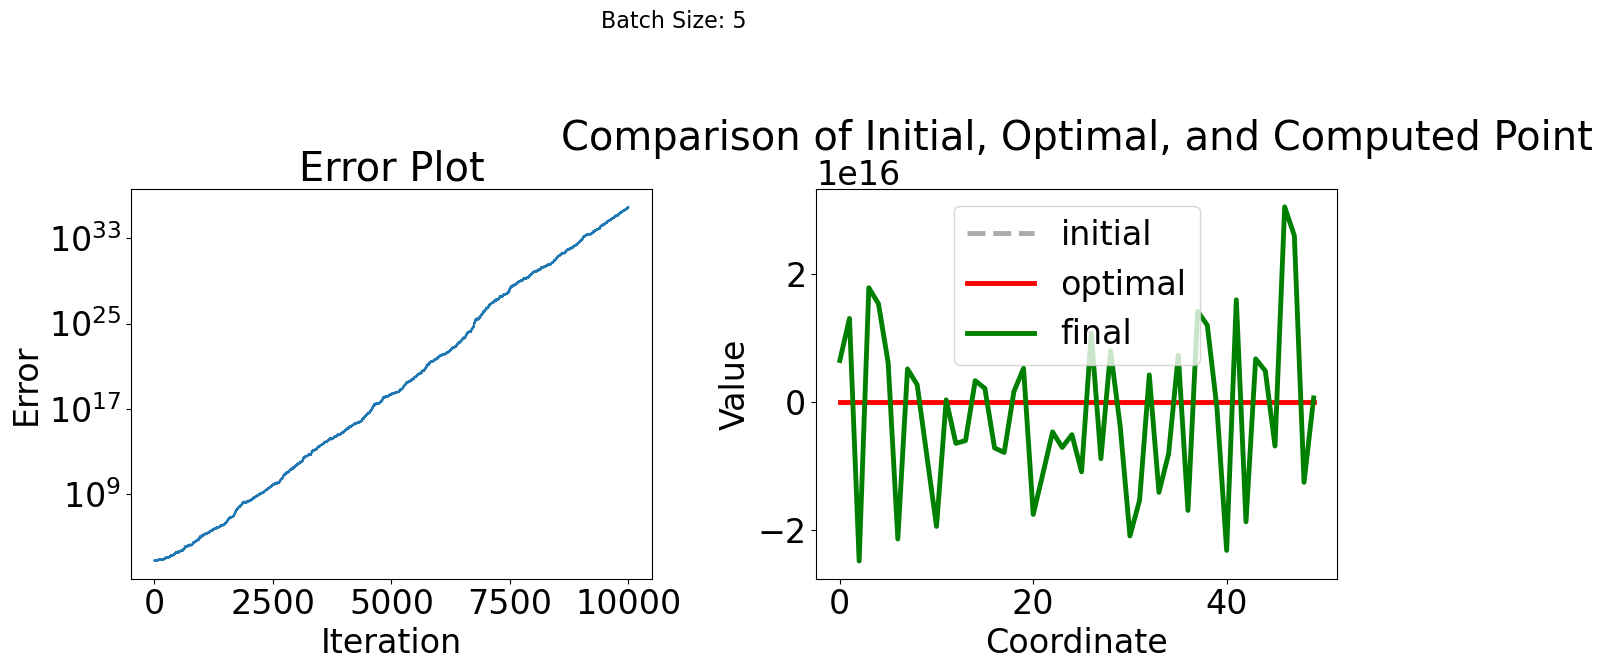

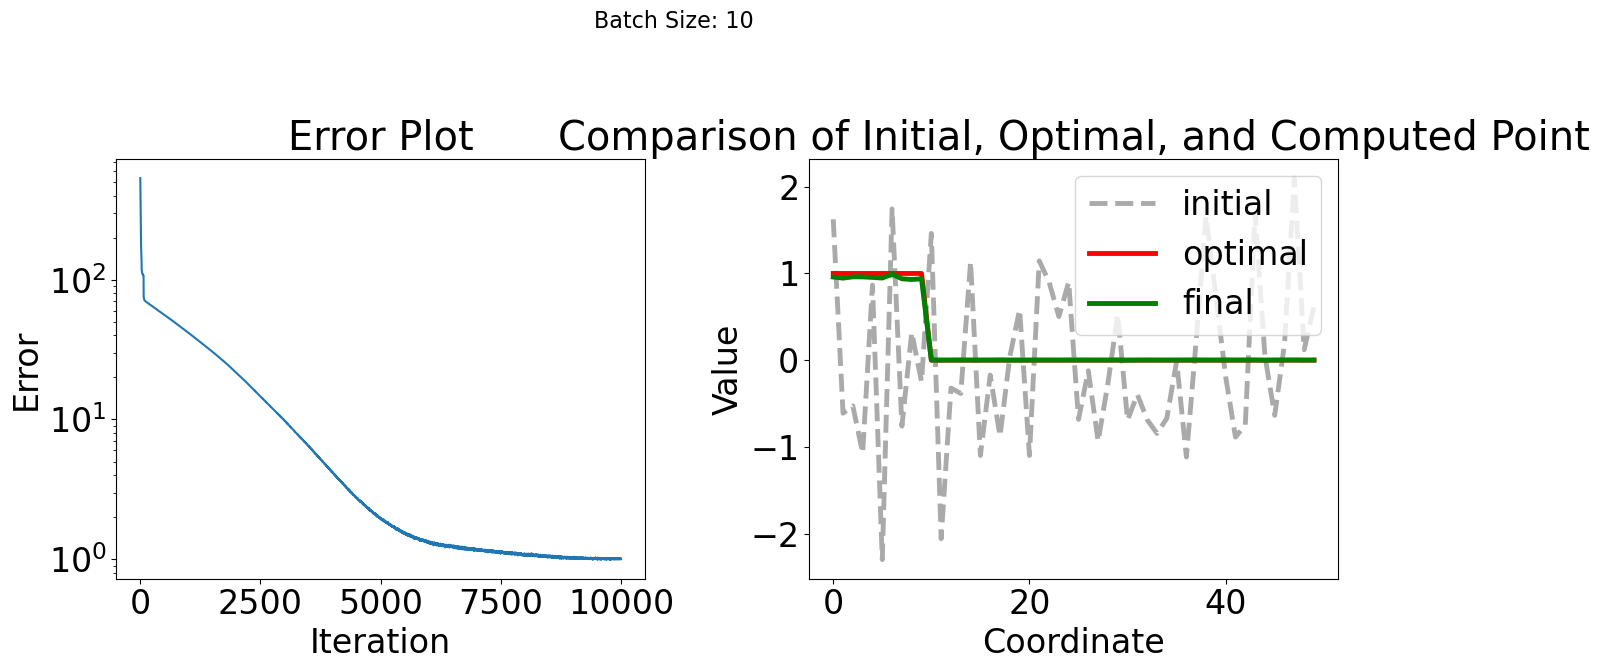

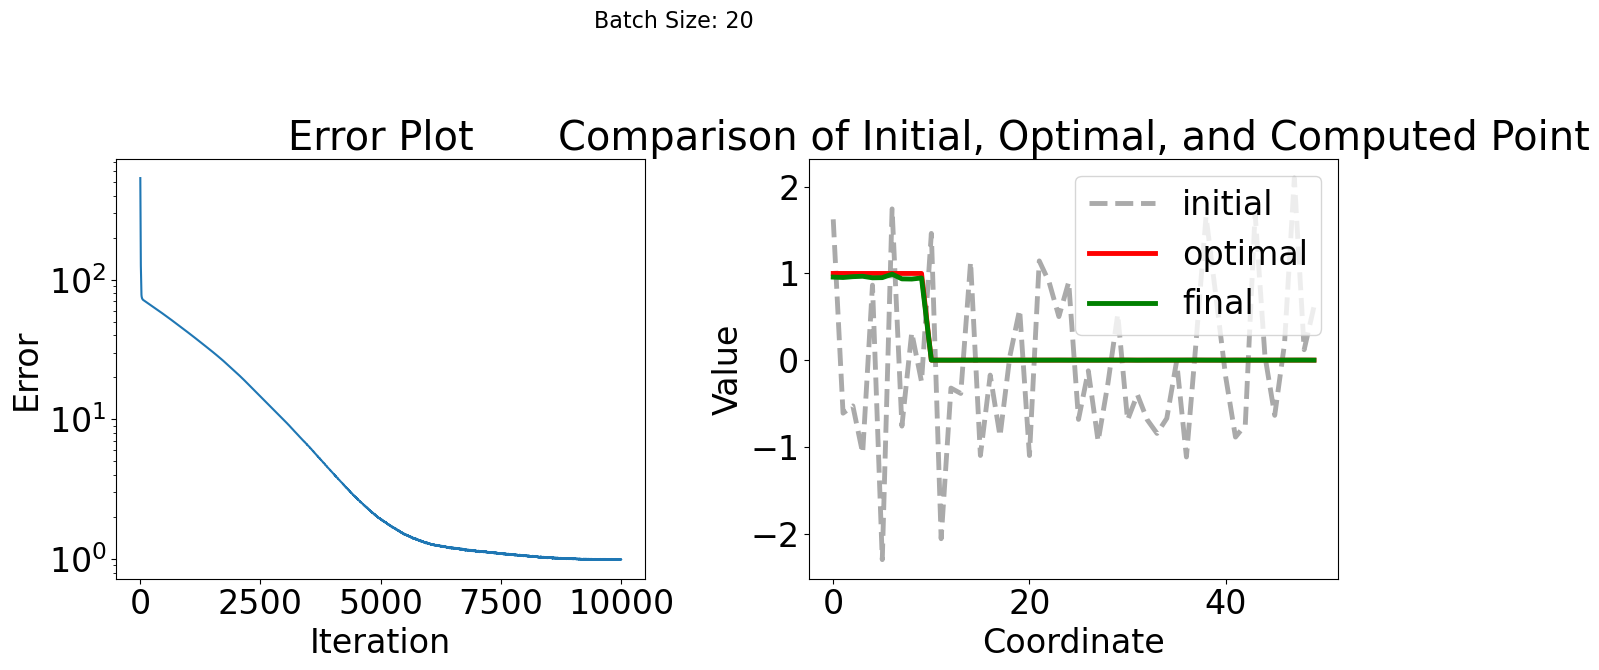

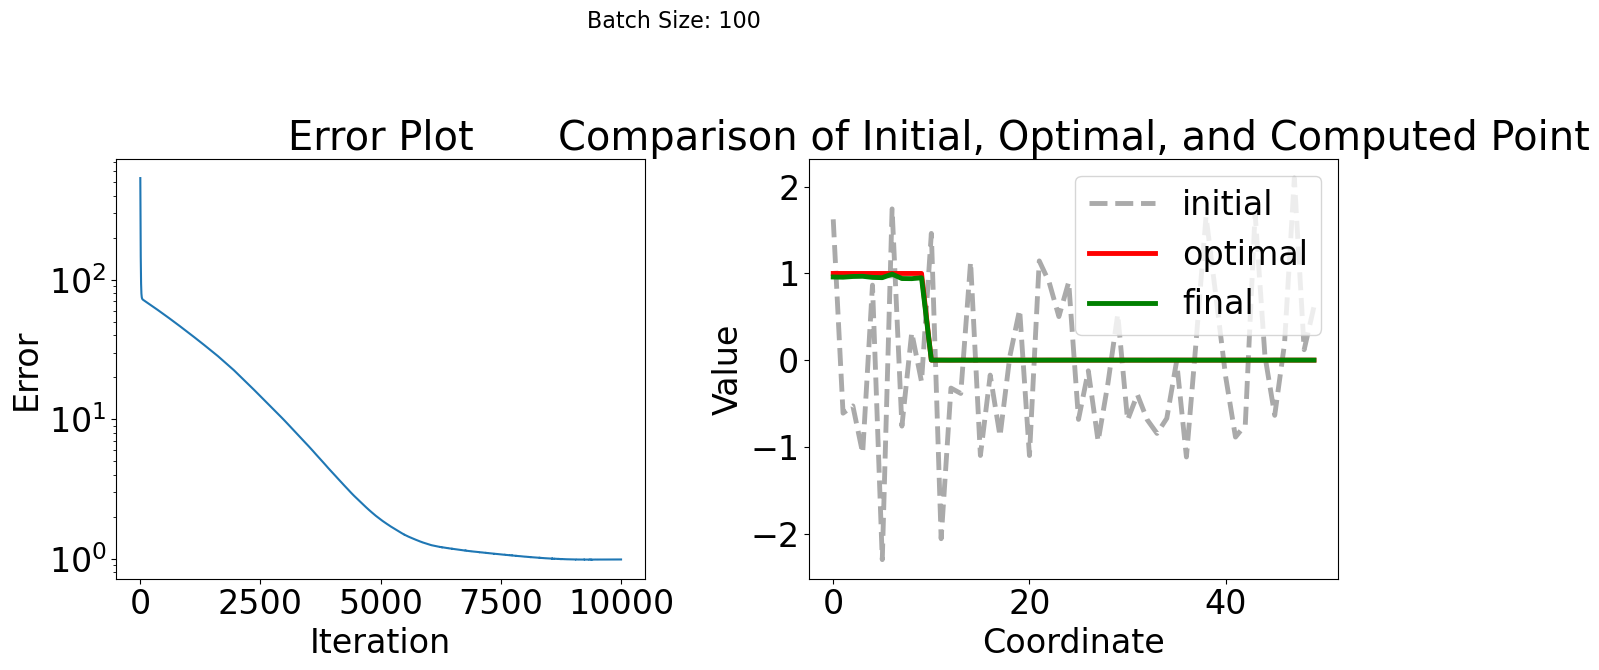

In [10]:
np.random.seed(1)

m, n = 100, 1000
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)

#iterations = [10000,10000,10000,10000,10000]
batchs = [5, 10, 20, 100]


list_xs__ = []

for index, batch in enumerate(batchs):
    # Perform stochastic gradient descent with Lasso
    list_xs__.append(gradient_descent(x0, [0.01] * 10000, lambda x: SGD_lasso_subgradient(A, b, x, alpha=0.04, batch_size=batch)))

    # Create a new figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Set the overall figure title to include the batch_size value
    fig.suptitle(f'Batch Size: {batch}', fontsize=16)

    # First subplot: error plot
    error_plot([lasso(A, b, x) for x in list_xs__[-1]], ax=axes[0])  # Pass axes[0] to error_plot
    axes[0].set_title('Error Plot')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Error')

    # Second subplot: comparison plot
    idxs = range(50)
    axes[1].plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial', **kwargs)
    axes[1].plot(idxs, x_opt[idxs], 'r-', label='optimal', **kwargs)
    axes[1].plot(idxs, list_xs__[index][-1][idxs], 'g-', label='final', **kwargs)
    axes[1].set_title('Comparison of Initial, Optimal, and Computed Point')
    axes[1].set_xlabel('Coordinate')
    axes[1].set_ylabel('Value')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the title

    # Show the figure with both subplots side by side
    plt.show()


In [11]:
# from sklearn.datasets import fetch_california_housing
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import zipfile
# import requests
# import io
# from sklearn.datasets import fetch_california_housing

# # # Download the ZIP file
# # url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip"


# #df = pd.read_csv("OnlineNewsPopularity.csv")
# df = fetch_california_housing()

# # Convert to a DataFrame for better handling
# X = df.data  # Feature matrix as a NumPy array
# y = df.target  # Target vector as a NumPy array

# # Train-test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [12]:
# print(df.shape)
# print(X.shape)
# print(y.shape)


In [13]:
# def SGD_least_squares_gradient(A, b, x, batch):
#     """Gradient of least squares objective at x."""
#     # Randomly choose an index from the array
#     random_index = np.random.choice(len(A), batch, replace=False)

#     # Use .iloc to select rows based on the integer index
#     random_observation = A.iloc[random_index,:]
#     return random_observation.T.dot(random_observation.dot(x) - b.iloc[random_index]) / batch

# def ell1_subgradient(x):
#     """Subgradient of the ell1-norm at x."""
#     g = np.ones(x.shape)
#     g[x < 0.] = -1.0
#     return g

# def SGD_lasso_subgradient(A, b, x, alpha=1, batch_size = 5):
#     """Subgradient of the lasso objective at x"""
#     return SGD_least_squares_gradient(A, b, x, batch=batch_size) + alpha*ell1_subgradient(x)


In [14]:
# np.random.seed(1)

# m, n = X.shape[0], X.shape[1]
# print(m,n)
# x0 = np.random.normal(0, 1, X.shape[1])  # n should match the number of features
# print(len(x0))
# #iterations = [10000,10000,10000,10000,10000]
# batchs = [10, 20]



# list_xs___ = []

# for index, batch in enumerate(batchs):

#     list_xs___.append(gradient_descent(x0,[0.001]*100 , lambda x: SGD_lasso_subgradient(X, y, x, alpha = 0.04, batch_size = batch)))  #[step]*10000  #iterations[index]
#     print(list_xs___[index][-1], len(list_xs___[-1]))
    
#     error_plot([lasso(X, y, x) for x in list_xs___[-1]])
    
#     plt.figure(figsize=(14,10))
#     plt.title('Comparison of initial, optimal, and computed point')
#     idxs = range(n)
#     plt.plot(idxs, x0, '--', color='#aaaaaa', label='initial', **kwargs)
#     #plt.plot(idxs, y, 'r-', label='optimal', **kwargs)
#     plt.plot(idxs, list_xs___[index][-1], 'g-', label='final', **kwargs)
#     plt.xlabel('Coordinate')
#     plt.ylabel('Value')
#     plt.legend()